In [1]:
import re

import pandas as pd


In [2]:
from src.hand_analysis.loader.load_last_split import load_last_analysis

#No hay eval set, solo train set
df, _ = load_last_analysis()

In [3]:
def sum_all_numbers(text):
    if pd.isna(text):
        return None
    numbers = re.findall(r'\d+\.?\d*', str(text))
    return sum(float(num) for num in numbers)


df['mmse_mistakes_count'] = df['mmse fallas'].apply(sum_all_numbers)

In [4]:
df[['mmse', 'mmse fallas', 'mmse_mistakes_count']].head(40)


,mmse,mmse fallas,mmse_mistakes_count
0,30.0,--,0.0
1,30.0,--,0.0
2,30.0,--,0.0
3,30.0,--,0.0
4,30.0,--,0.0
5,30.0,--,0.0
6,30.0,--,0.0
7,30.0,--,0.0
8,30.0,--,0.0
9,30.0,--,0.0


In [5]:
cognitive_columns = ['mmse', 'tmt_a_raw', 'tmt_a_z',
                     'tmt_b_raw', 'tmt_b_z', 'digit_symbol_raw',
                     'digit_symbol_z', 'forward_digit_span_raw', 'forward_digit_span_z',
                     'backward_digit_span_raw', 'backward_digit_span_z',
                     'clock_drawing_test', ]

demographic_columns = ['sex', 'age', 'years_of_education']

#select only the first row for each subject_id
df_subject = df.drop_duplicates(subset='subject_id', keep='first')
df_metadata_cognitive = df_subject[['subject_id', 'group'] + demographic_columns + cognitive_columns].copy()

In [6]:
import scipy
from collections import Counter

min_age = 51
metadata_control = df_metadata_cognitive[df_metadata_cognitive['group'] == 'control']
metadata_control = metadata_control[metadata_control['age'] >= min_age]
metadata_mci = df_metadata_cognitive[df_metadata_cognitive['group'] == 'mci']
metadata_mci = metadata_mci[metadata_mci['age'] >= min_age]

for var in demographic_columns:
    if var == "sex":
        # Combine these lists into a 2x2 contingency table
        # Count occurrences of each category (1 = Female, 0 = Male) in each group
        mci_counts = Counter(metadata_mci["sex"])
        control_counts = Counter(metadata_control["sex"])

        # Create the contingency table
        contingency_table = [
            [mci_counts[1], control_counts[1]],  # Female counts  (mci and control)
            [mci_counts[0], control_counts[0]],  # Male counts (mci and control)
        ]
        # Perform Chi-square test
        chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency_table)
        print(f"chi2: {var}, p={p:.3f}")
        continue
    t_stat, p_value = scipy.stats.ttest_ind(
        metadata_mci[var], metadata_control[var], nan_policy="omit"
    )
    print(f"T-test: {var}, p={p_value:.5f}")

print(len(metadata_control))
print(len(metadata_mci))

chi2: sex, p=0.714
T-test: age, p=0.07199
T-test: years_of_education, p=0.24421
40
51


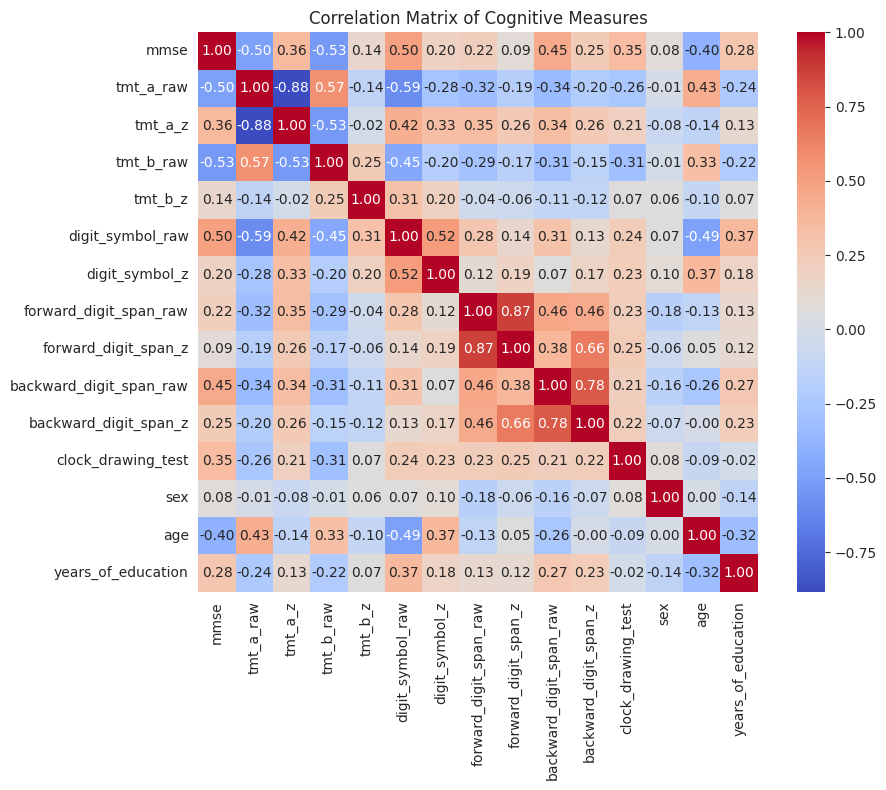

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = df[cognitive_columns + demographic_columns].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Cognitive Measures")
plt.tight_layout()
plt.show()

### 1. Filter by validity, age, and minimum number of trials


In [8]:
import numpy as np

# 1. Filter by validity, age, and minimum number of trials
min_age = 56
min_number_of_trials_by_type = 1
only_ratio = False
only_part_b = False

print("Initial unique subjects:", df['subject_id'].nunique())

df_valid = df[df["is_valid"]]
print("After filtering valid trials:", df_valid['subject_id'].nunique())

df_valid = df_valid[df_valid['age'] >= min_age]
print(f"After filtering by age >= {min_age}:", df_valid['subject_id'].nunique())

# Keep subjects with at least one valid PART_A and PART_B trial
valid_counts = df_valid.groupby(['subject_id', 'trial_type']).size().unstack(fill_value=0)

eligible_subjects = valid_counts[
    (valid_counts.get('PART_A', 0) >= min_number_of_trials_by_type) &
    (valid_counts.get('PART_B', 0) >= min_number_of_trials_by_type)
    ].index

df_valid = df_valid[df_valid['subject_id'].isin(eligible_subjects)]
print("After filtering by min number of trials:", df_valid['subject_id'].nunique())

Initial unique subjects: 93
After filtering valid trials: 87
After filtering by age >= 56: 80
After filtering by min number of trials: 75


### 2. Pivot digital variables


In [9]:
# 2. Pivot digital variables
digital_tmt_vars = [
    'rt', 'total_distance', 'non_cut_correct_targets_touches', 'non_cut_zigzag_amplitude', 'non_cut_rt',
    'mean_speed', 'std_speed', 'peak_speed', 'mean_acceleration', 'std_acceleration',
    'peak_acceleration', 'mean_abs_acceleration', 'std_abs_acceleration',
    'peak_abs_acceleration', 'mean_negative_acceleration',
    'std_negative_acceleration', 'peak_negative_acceleration',
    'hesitation_time', 'travel_time', 'search_time', 'hesitation_distance',
    'travel_distance', 'search_distance', 'hesitation_avg_speed',
    'travel_avg_speed', 'search_avg_speed', 'state_transitions',
    'total_hesitations', 'average_duration',
    'max_duration', 'zigzag_amplitude', 'distance_difference_from_ideal',
    'area_difference_from_ideal', 'intra_target_time', 'inter_target_time'
]

df_digital_tmt = df_valid.pivot_table(
    index='subject_id',
    columns='trial_type',
    values=digital_tmt_vars
)

# Flatten column names (e.g., mean_speed_PART_A)
df_digital_tmt.columns = [f"{var}_{ttype}" for var, ttype in df_digital_tmt.columns]

### 3. Compute B/A ratios

In [10]:
# 3. Compute B/A ratios
part_a_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_A')]
part_b_cols = [col for col in df_digital_tmt.columns if col.endswith('_PART_B')]
common_vars = [col.replace('_PART_A', '') for col in part_a_cols if
               f"{col.replace('_PART_A', '')}_PART_B" in part_b_cols]

for var in common_vars:
    df_digital_tmt[f"{var}_B_A_ratio"] = df_digital_tmt[f"{var}_PART_B"] / df_digital_tmt[f"{var}_PART_A"]

df_digital_tmt.replace([np.inf, -np.inf], np.nan, inplace=True)

### 4. Add validity percentage

In [11]:
# 4. Add validity percentage
df_grouped = df_valid.groupby(['subject_id', 'trial_type'])['is_valid'].sum().unstack()
df_grouped.columns = ['is_valid_sum_A', 'is_valid_sum_B']
df_grouped['is_valid_sum_A'] = (df_grouped['is_valid_sum_A'] / 10) * 100
df_grouped['is_valid_sum_B'] = (df_grouped['is_valid_sum_B'] / 10) * 100

df_digital_tmt = df_digital_tmt.merge(df_grouped, left_index=True, right_index=True)

### 5. Merge with cognitive metadata -->
#### lo tenemos que hacer porque se partio previamente


In [12]:

# 5. Merge with cognitive metadata

df_digital_tmt_with_target = df_digital_tmt.merge(
    df_metadata_cognitive[['subject_id', 'group']], on='subject_id', validate='one_to_one'
).set_index('subject_id')

df_digital_tmt_with_target['group'] = (df_digital_tmt_with_target['group'].str
                                       .replace('mci', '1')
                                       .replace('control', '0').astype(int))

# 6. Demographic da

### 6. Demographic data

In [13]:
# 6. Demographic data
dataset_big = df_digital_tmt_with_target.index.tolist()

demographic_df = df_metadata_cognitive.loc[
    df_metadata_cognitive['subject_id'].isin(dataset_big),
    ['subject_id', 'sex', 'age', 'years_of_education', 'group']
].copy()

demographic_df['group'] = demographic_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
demographic_df.set_index('subject_id', inplace=True)

### 7. Non-digital data

In [14]:
# 7. Non-digital data
non_digital_vars = ['mmse', 'tmt_a_raw', 'tmt_a_z', 'tmt_b_raw', 'tmt_b_z',
                    'digit_symbol_raw', 'digit_symbol_z', 'forward_digit_span_raw',
                    'forward_digit_span_z', 'backward_digit_span_raw', 'backward_digit_span_z',
                    'clock_drawing_test']

non_digital_df = df_metadata_cognitive.loc[
    df_metadata_cognitive['subject_id'].isin(dataset_big),
    ['subject_id'] + non_digital_vars + ['group']
].copy()

non_digital_df['group'] = non_digital_df['group'].str.replace('mci', '1').replace('control', '0').astype(int)
non_digital_df.set_index('subject_id', inplace=True)

### 8. Eye movement data (no lo tengo)

In [15]:
# 8. Eye movement data
#df_eye = pd.read_csv(eye_movements_path)
#df_eye['group'] = df_eye['group'].str.replace('MCI', '1').replace('control', '0').astype(int)

df_digital_hand_and_eye = df_digital_tmt_with_target  #.reset_index().merge(
#  df_eye, on='suj', validate='one_to_one', suffixes=('', '_eye')
#).set_index('suj')

# df_digital_hand_and_eye['group'] = df_digital_hand_and_eye['group']  # keep consistent naming
# df_digital_hand_and_eye.drop(columns=['group_eye'], inplace=True, errors='ignore')
# cols = [col for col in df_digital_hand_and_eye.columns if col != 'group'] + ['group']
# df_digital_hand_and_eye = df_digital_hand_and_eye[cols]

### 9. Optional: filter to only PART_B variables

In [16]:

# 9. Optional: filter to only PART_B variables
if only_part_b:
    cols_b = [col for col in df_digital_tmt_with_target.columns if col.endswith(('B', 'b'))]
    df_digital_tmt_with_target = df_digital_tmt_with_target[cols_b + ['group']]
    df_digital_hand_and_eye = df_digital_hand_and_eye[cols_b + ['group']]

if only_ratio:
    print("ONLY RATIO")
    cols_ratio = [i for i in df_digital_tmt_with_target.columns if '_ratio' in i]
    df_digital_tmt_with_target = df_digital_tmt_with_target[cols_ratio + ['group']]
    print(df_digital_tmt_with_target.columns)
    df_digital_hand_and_eye = df_digital_hand_and_eye[cols_ratio + ['group']]

digital_test_less_subjects = df_digital_tmt_with_target.loc[df_digital_hand_and_eye.index]
non_digital_test_less_subjects = non_digital_df.loc[df_digital_hand_and_eye.index]

### 10. Save the final datasets

In [17]:
processed_path = '../data/processed/'

print("Digital TMT with target group:")
print(df_digital_tmt_with_target['group'].value_counts())
df_digital_tmt_with_target.to_csv(processed_path + 'df_digital_tmt_with_target.csv', index_label='subject_id')
print("-" * 50)

print("Demographic data:")
print(demographic_df['group'].value_counts())
demographic_df.to_csv(processed_path + 'demographic_df.csv', index_label='subject_id')
print("-" * 50)

print("Non-digital data:")
print(non_digital_df['group'].value_counts())
non_digital_df.to_csv(processed_path + 'non_digital_df.csv', index_label='subject_id')
print("-" * 50)

print("Digital hand and eye data:")
print(df_digital_hand_and_eye['group'].value_counts())
df_digital_hand_and_eye.to_csv(processed_path + 'df_digital_hand_and_eye.csv', index_label='subject_id')
print("-" * 50)

print("Digital test with less subjects:")
print(digital_test_less_subjects['group'].value_counts())
digital_test_less_subjects.to_csv(processed_path + 'digital_test_less_subjects.csv', index_label='subject_id')
print("-" * 50)

print("Non-digital test with less subjects:")
print(non_digital_test_less_subjects['group'].value_counts())
non_digital_test_less_subjects.to_csv(processed_path + 'non_digital_test_less_subjects.csv', index_label='subject_id')

Digital TMT with target group:
group
1    42
0    33
Name: count, dtype: int64
--------------------------------------------------
Demographic data:
group
1    42
0    33
Name: count, dtype: int64
--------------------------------------------------
Non-digital data:
group
1    42
0    33
Name: count, dtype: int64
--------------------------------------------------
Digital hand and eye data:
group
1    42
0    33
Name: count, dtype: int64
--------------------------------------------------
Digital test with less subjects:
group
1    42
0    33
Name: count, dtype: int64
--------------------------------------------------
Non-digital test with less subjects:
group
1    42
0    33
Name: count, dtype: int64


In [18]:
demographic_df.columns.tolist()


['sex', 'age', 'years_of_education', 'group']